In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Airlines Flights Dataset for Different Cities**<br>
    The Flights Booking Dataset of various Airlines is a scraped datewise from a famous website in a structured format. The dataset contains the records of flight travel details between the cities in India. Here, multiple features are present like Source & Destination City, Arrival & Departure Time, Duration & Price of the flight etc.
    This data is available as a CSV file. We are going to analyze this data set using the Pandas DataFrame.
    This analyse will be helpful for those working in Airlines, Travel domain.

## **These are the main Features/Columns available in the dataset :**

1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.

2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.

3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.

4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.

5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.

6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.

7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.

8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.

9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.

10) Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.

11) Price: Target variable stores information of the ticket price.

In [6]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns 

In [7]:
df="airlines_flights_data.csv"

In [8]:
airline_df=pd.read_csv(df)
airline_df.sample(7)

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
83801,83801,Vistara,UK-851,Mumbai,Early_Morning,two_or_more,Night,Chennai,Economy,13.25,47,8130
14771,14771,Vistara,UK-933,Delhi,Afternoon,one,Night,Bangalore,Economy,7.33,25,4496
199946,199946,Air_India,AI-440,Chennai,Early_Morning,one,Morning,Kolkata,Economy,26.83,23,5098
195294,195294,GO_FIRST,G8-302,Chennai,Early_Morning,one,Evening,Bangalore,Economy,14.67,21,4612
293699,293699,Vistara,UK-822,Chennai,Morning,one,Night,Bangalore,Business,11.17,8,44144
150828,150828,Vistara,UK-720,Kolkata,Early_Morning,one,Night,Chennai,Economy,15.58,31,5910
61640,61640,SpiceJet,SG-251,Mumbai,Evening,one,Night,Kolkata,Economy,25.67,2,7728


In [9]:
airline_df.shape

(300153, 12)

## **EDA and Analysis**

In [10]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


## **Descriptive Statistics**

In [11]:
def descriptive_analysis(dataset:pd.DataFrame,n_cols):
    stats_df=dataset[n_cols].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

    stats_df.loc["skew"]=dataset[n_cols].skew() #adding skewness
    stats_df.loc["kurtosis"]=dataset[n_cols].kurtosis() #adding kurtosis

    #Detect outlier(IQR method)
    q1= dataset[n_cols].quantile(0.25)
    q3=dataset[n_cols].quantile(0.75)
    IQR=q3 - q1

    outlier_dect=((dataset[n_cols] < (q1 -1.5*IQR)) | (dataset[n_cols] > (q3 + 1.5 * IQR)))
    outlier_count = outlier_dect.sum().rename('outlier_count')
    stats_df =pd.concat([stats_df,outlier_count.to_frame().T])
    return stats_df 
num_cols =["index","duration","days_left","price"]
num_stats=descriptive_analysis(airline_df,num_cols)
print(num_stats)

                      index       duration      days_left          price
count          3.001530e+05  300153.000000  300153.000000  300153.000000
mean           1.500760e+05      12.221021      26.004751   20889.660523
std            8.664685e+04       7.191997      13.561004   22697.767366
min            0.000000e+00       0.830000       1.000000    1105.000000
25%            7.503800e+04       6.830000      15.000000    4783.000000
50%            1.500760e+05      11.250000      26.000000    7425.000000
75%            2.251140e+05      16.170000      38.000000   42521.000000
95%            2.851444e+05      25.920000      47.000000   63277.000000
99%            2.971505e+05      29.080000      49.000000   76736.000000
max            3.001520e+05      49.830000      49.000000  123071.000000
skew           8.391184e-17       0.602899      -0.035464       1.061377
kurtosis      -1.200000e+00      -0.268996      -1.156215      -0.396293
outlier_count  0.000000e+00    2110.000000       0.

## **Distribution & Outlier Visualization**

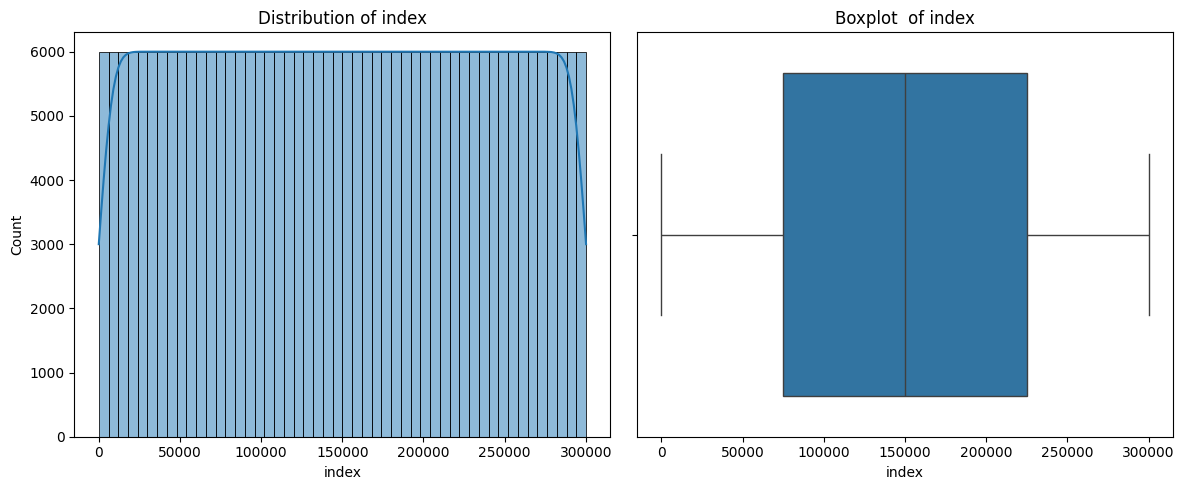

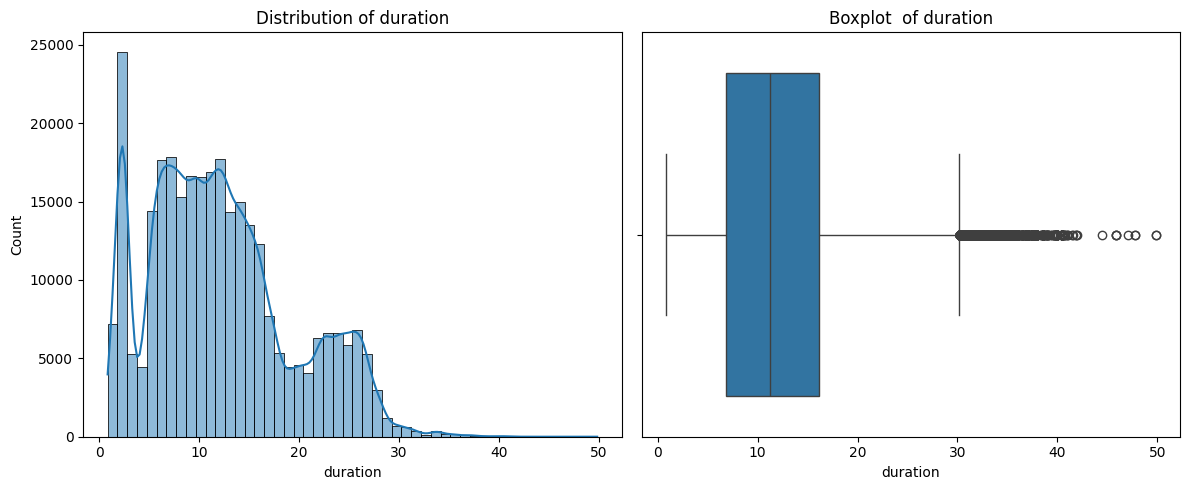

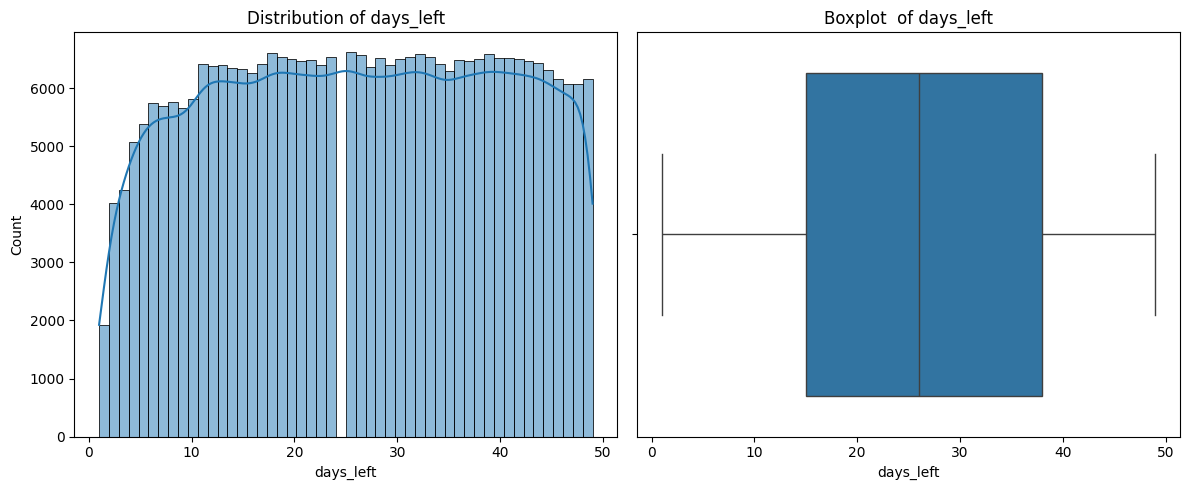

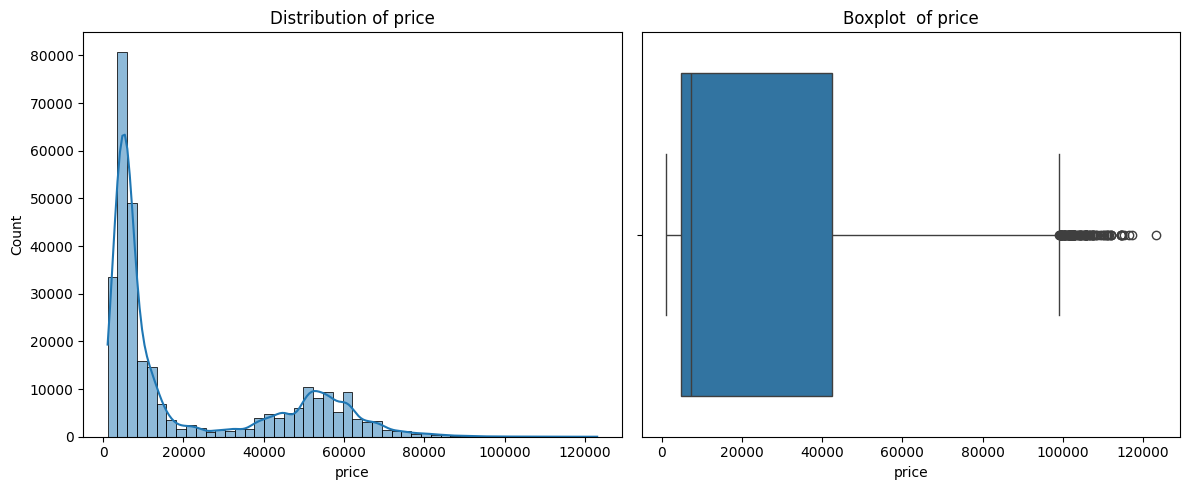

In [12]:
def plot_numerical_distribution(df,num_cols):
    for col in num_cols:
        plt.figure(figsize=(12,5))

        #hist +kde
        plt.subplot(1,2,1)
        sns.histplot(df[col],kde =True,bins=50)
        plt.title(f"Distribution of {col}")

        #outlier
        plt.subplot(1,2,2)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot  of {col}")
        plt.tight_layout()
        plt.show()
plot_numerical_distribution(airline_df,num_cols)

## **Correlation Analysis**

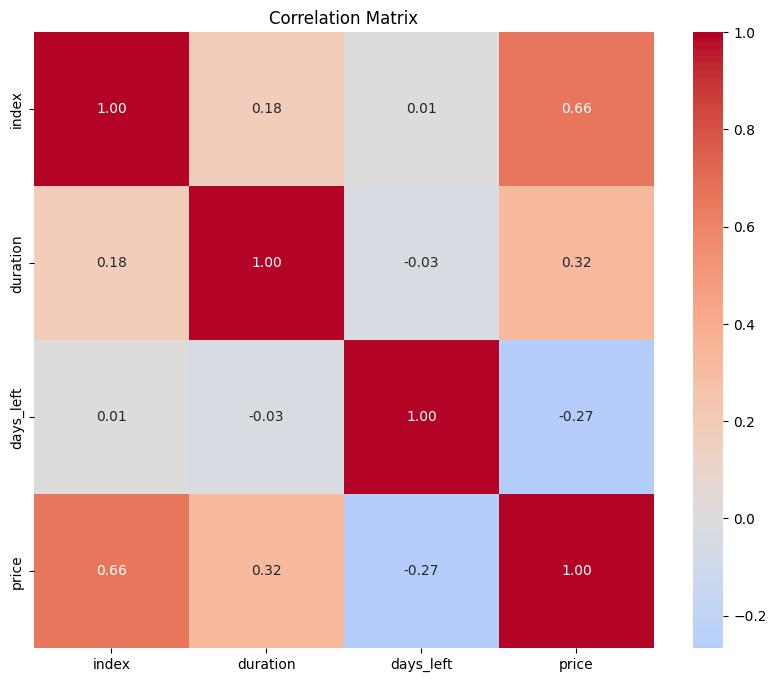

In [13]:
def plot_Correlation_matrix(df,n_cols):
    corr_m=df[n_cols].corr(method="spearman")
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_m,annot=True,cmap="coolwarm",center=0,fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()
plot_Correlation_matrix(airline_df,num_cols)

## **Frequency Analysis**

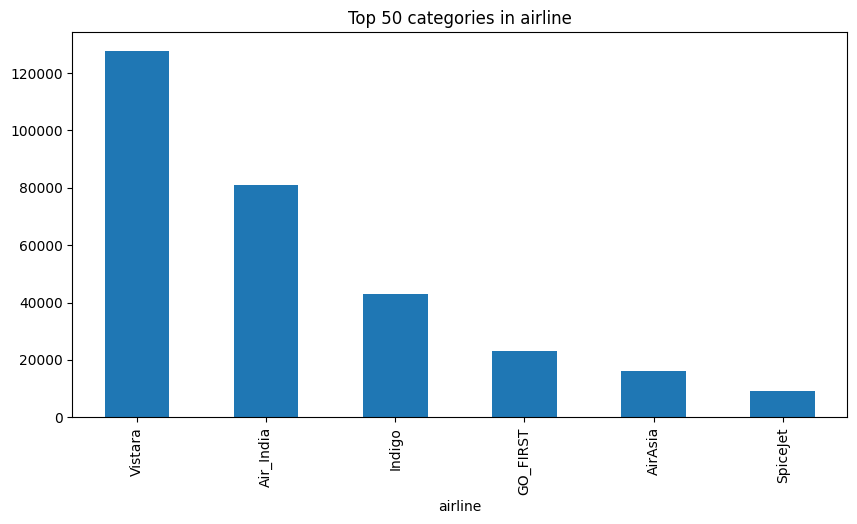

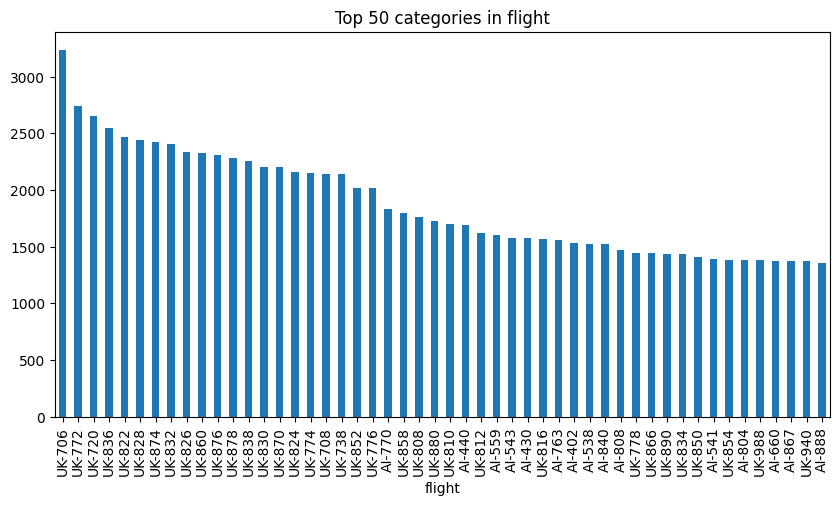

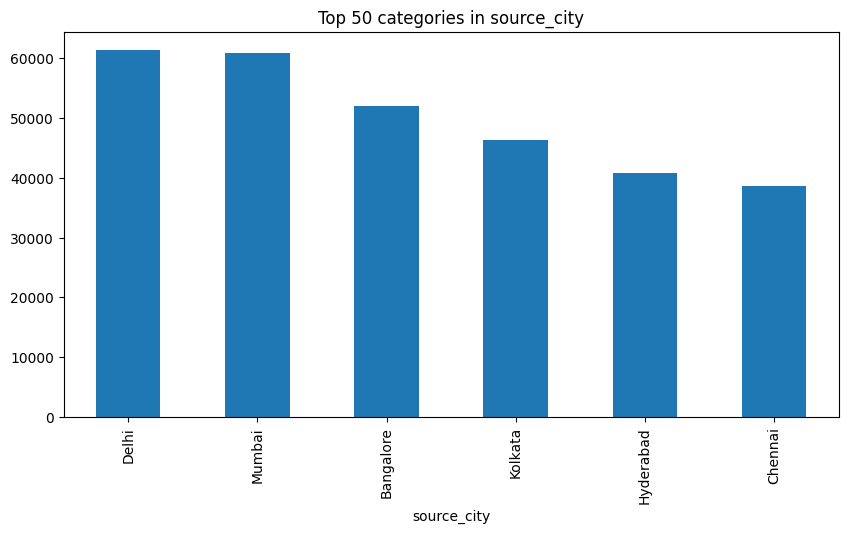

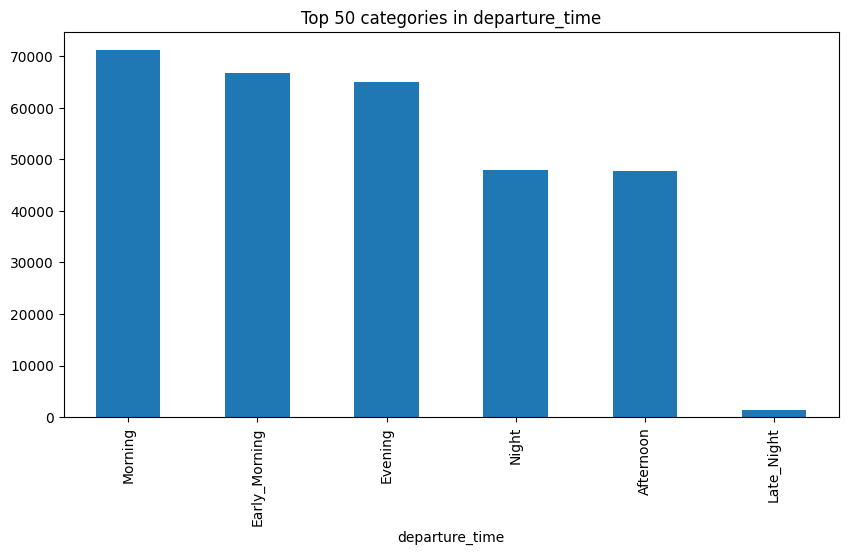

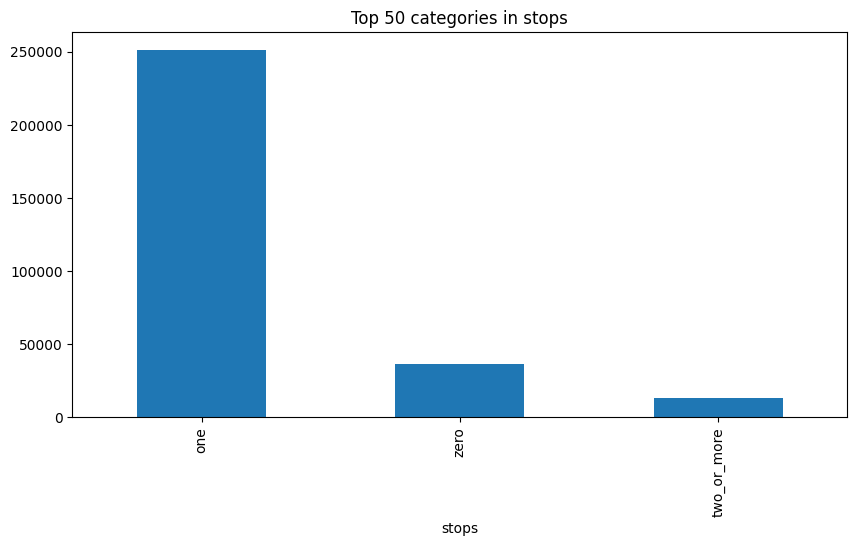

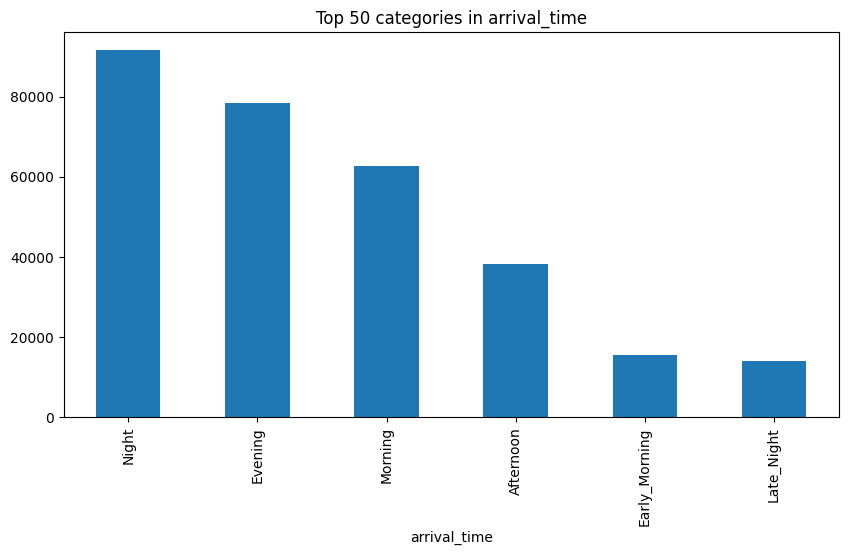

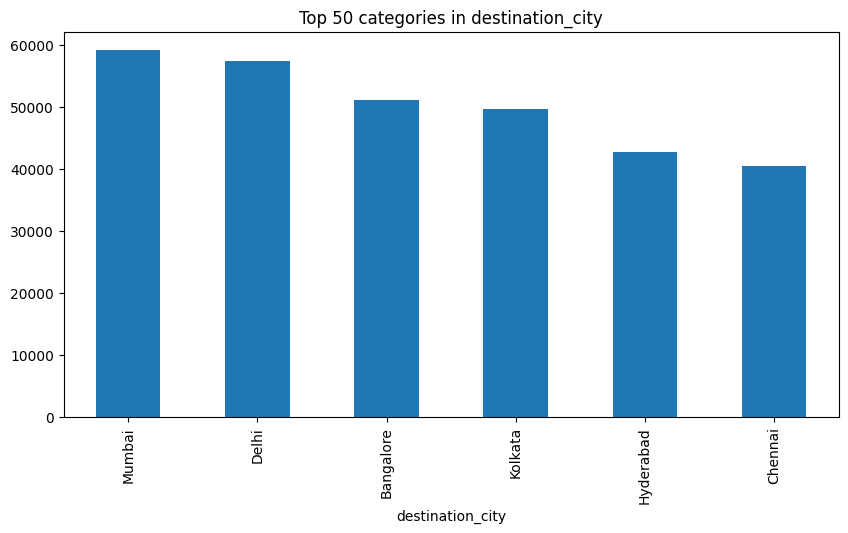

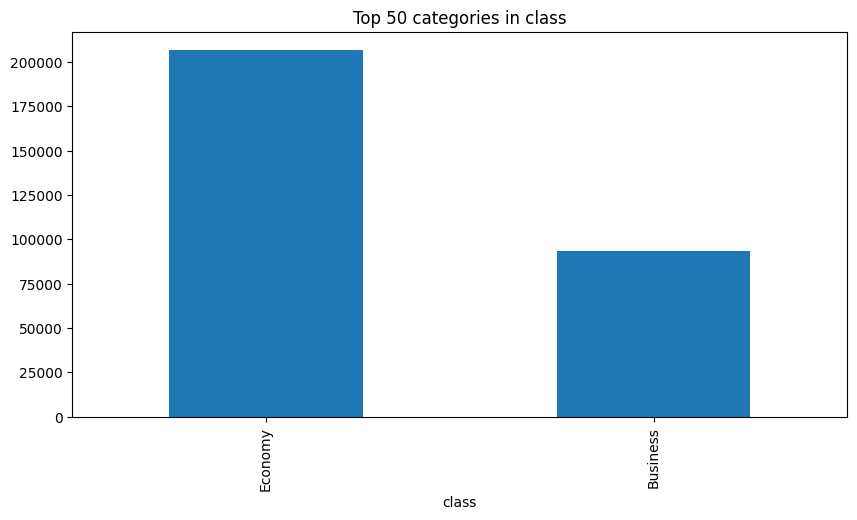

In [14]:
def Freq_analysis(df:pd.DataFrame,cat_columns,top_n:int=50):
    for col in cat_columns:
        freq=df[col].value_counts().nlargest(top_n)

        #Plot
        plt.figure(figsize=(10,5))
        freq.plot(kind="bar")
        plt.title(f"Top {top_n} categories in {col}")
        plt.xticks(rotation=90)
        plt.show()
cat_cols=airline_df.select_dtypes(include=["object"]).columns
Freq_analysis(airline_df,cat_cols)

## **Cardinality & Rare Categories**

In [15]:
def analyze_cardinality(df,cat_cols,rare_threshold=0.01):
    cardinality_report={}
    for col in cat_cols:
        n_unique=df[col].nunique()
        freq=df[col].value_counts(normalize=True)
        rare_cats=freq[freq <rare_threshold].index.tolist()
        cardinality_report[col]={
            'N_unique': n_unique,
            "Rare_categories":rare_cats,
            "Sugesstion":"Drop or bin rare categories" if rare_cats else "OK"
        }
    return pd.DataFrame(cardinality_report).T
# cat_cols=["airline","flight","source_city","departure_time","stops","arrival_time","destination_city","class"]
cardinality_report=analyze_cardinality(airline_df,cat_cols)
print(cardinality_report)

                 N_unique                                    Rare_categories  \
airline                 6                                                 []   
flight               1561  [UK-772, UK-720, UK-836, UK-822, UK-828, UK-87...   
source_city             6                                                 []   
departure_time          6                                       [Late_Night]   
stops                   3                                                 []   
arrival_time            6                                                 []   
destination_city        6                                                 []   
class                   2                                                 []   

                                   Sugesstion  
airline                                    OK  
flight            Drop or bin rare categories  
source_city                                OK  
departure_time    Drop or bin rare categories  
stops                                  

## **Chi-Square Test (Categorical Associations)**

In [16]:
def chi_square_test(df,cat1,cat2):
    contingency_table=pd.crosstab(df[cat1],df[cat2])
    chi2,p,dof,expected=chi2_contingency(contingency_table)
    n=contingency_table.sum().sum()
    cramers_v =np.sqrt(chi2/n*(min(contingency_table.shape)-1))
    return {
        "Chi2_stat":chi2,
        "p_value":p,
        "Cramers_v": cramers_v,
        "interpretation":"Strong association" if cramers_v >0.25 else "Weak/moderate"
    }
result=chi_square_test(airline_df,"airline","source_city")#checking relation between airlines and source_city
print(result)

{'Chi2_stat': np.float64(5740.747763040632), 'p_value': np.float64(0.0), 'Cramers_v': np.float64(0.3092415850132074), 'interpretation': 'Strong association'}


In [17]:
result=chi_square_test(airline_df,"airline","flight")#checking relation between airlines and flight
print(result)

{'Chi2_stat': np.float64(1500765.0), 'p_value': np.float64(0.0), 'Cramers_v': np.float64(5.0), 'interpretation': 'Strong association'}


In [18]:
result=chi_square_test(airline_df,"airline","departure_time")#checking relation between airlines and departure_time
print(result)

{'Chi2_stat': np.float64(9762.999143131447), 'p_value': np.float64(0.0), 'Cramers_v': np.float64(0.4032786991570907), 'interpretation': 'Strong association'}


In [ ]:
result=chi_square_test(airline_df,"airline","stops")#checking relation between airlines and stops
print(result)

In [ ]:
result=chi_square_test(airline_df,"airline","arrival_time")#checking relation between airlines and arrival_time
print(result)

In [ ]:
result=chi_square_test(airline_df,"airline","destination_city")#checking relation between airlines and destination_city
print(result)

In [ ]:
result=chi_square_test(airline_df,"airline","class")#checking relation between airlines and class
print(result)

## **Combined Analysis**

In [ ]:
def plot_grouped_stats(df,num_col,cat_col):
    grouped=df.groupby(cat_col)[num_col].agg(['mean',"median","std","count"])

    plt.figure(figsize=(12,6))
    sns.barplot(x=grouped.index,y=grouped["mean"])
    plt.title(f"Mean {num_col} by {cat_col}")
    plt.xticks(rotation=90)
    plt.show()
    return grouped
plot_grouped_stats(airline_df,"duration","airline")

## **Not completed (on process)**